#  Housekeeping Unit Test

This notebook contains a Unit Test for the housekeeping information from the Observatory Simulator.

### Starting the Observatory Simulator

Remember that whenever you power-cycle the Observatory Simulator, you should set `preload=True` below.

When you are running this notbook and it has *not* been power cycled, you should set `preload=False`.

In [1]:
from tessfpe.dhu.fpe import FPE
from tessfpe.dhu.unit_tests import check_house_keeping_voltages
fpe1 = FPE(1, debug=False, preload=False, FPE_Wrapper_version='6.1.1')
print fpe1.version
if check_house_keeping_voltages(fpe1):
    print "Wrapper load complete. Interface voltages OK."

Observatory Simulator Version 1.6c - Oct  8 2015 11:55:03
Wrapper load complete. Interface voltages OK.


As a quick diagnostic, we start and stop capture frames.

In [2]:
fpe1.cmd_start_frames()

'Starting frames...'

In [3]:
fpe1.cmd_stop_frames()

'Frames Stopped...'

Now we collect the measurements; this will make 10 sets of samples for heater currents that are between 0 and 150 mA, spaced out by 10 mA.

In [4]:
from tessfpe.data.operating_parameters import operating_parameters
operating_parameters["heater_1_current"]
high = operating_parameters["heater_1_current"]["high"]

In [5]:
measurements = []
for i in range(5,int(high)*10,10):
    a = i % high
    b = (i + 100) % high
    c = abs((high - i) % high)
    fpe1.ops.heater_1_current = a
    fpe1.ops.heater_2_current = b
    fpe1.ops.heater_3_current = c
    fpe1.ops.send()
    measurements.append({"set": {"heater_1_current": a, 
                                 "heater_2_current": b,
                                 "heater_3_current": c},
                         "measured": {"heater_1_current": fpe1.house_keeping["analogue"]["heater_1_current"],
                                      "heater_2_current": fpe1.house_keeping["analogue"]["heater_2_current"],
                                      "heater_3_current": fpe1.house_keeping["analogue"]["heater_3_current"]}})
len(measurements)

227

Make sure to run the following cell so that the heaters can "chill out".

In [6]:
fpe1.ops.heater_1_current = fpe1.ops.heater_1_current.low
fpe1.ops.heater_2_current = fpe1.ops.heater_2_current.low
fpe1.ops.heater_3_current = fpe1.ops.heater_3_current.low
fpe1.ops.send()

## Plots

Let's first plot the `set` value on the $x$ axis versus the `measured` value on the $y$ axis to test how well calibrated the sensors are:

In [7]:
x1 = [i["set"]["heater_1_current"] for i in measurements]
y1 = [j["measured"]["heater_1_current"] for j in measurements]
x2 = [i["set"]["heater_2_current"] for i in measurements]
y2 = [j["measured"]["heater_2_current"] for j in measurements]
x3 = [i["set"]["heater_3_current"] for i in measurements]
y3 = [j["measured"]["heater_3_current"] for j in measurements]

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [9]:
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


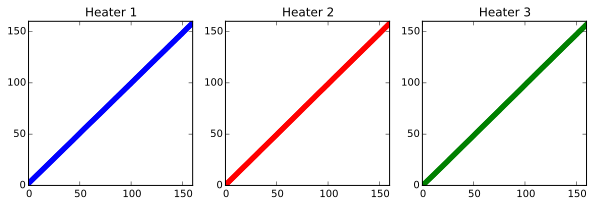

In [10]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(331, aspect='equal')
ax1.set_title('Heater 1')
ax1.scatter(x1,y1,color='blue')
ax1.locator_params(nbins=4)
ax1.set_xlim([0,160])
ax1.set_ylim([0,160])

ax2 = f.add_subplot(332, aspect='equal')
ax2.set_title('Heater 2')
ax2.scatter(x2,y2,color='red')
ax2.locator_params(nbins=4)
ax2.set_xlim([0,160])
ax2.set_ylim([0,160])

ax3 = f.add_subplot(333, aspect='equal')
ax3.set_title('Heater 3')
ax3.scatter(x3,y3,color='green')
ax3.locator_params(nbins=4)
ax3.set_xlim([0,160])
ax3.set_ylim([0,160])
plt.show()

As we can see, the measured heater values from the housekeeping are roughly the same as the values set values, up to an *affine transformation*. To see this, it is helpful to compute `measured - set` to see the errors:

In [11]:
err1 = map(lambda y,x: y-x, y1, x1)
err2 = map(lambda y,x: y-x, y2, x2)
err3 = map(lambda y,x: y-x, y3, x3)

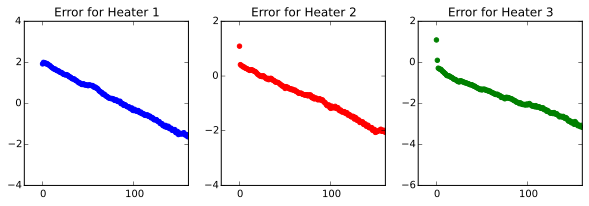

In [12]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(331)
ax1.set_title('Error for Heater 1')
ax1.locator_params(nbins=4)
ax1.set_xlim([-20,160])
ax1.scatter(x1,err1,color='blue')

ax2 = f.add_subplot(332)
ax2.set_title('Error for Heater 2')
ax2.locator_params(nbins=4)
ax2.set_xlim([-20,160])
ax2.scatter(x2,err2,color='red')

ax3 = f.add_subplot(333)
ax3.set_title('Error for Heater 3')
ax3.locator_params(nbins=4)
ax3.set_xlim([-20,160])
ax3.scatter(x3,err3,color='green')
plt.show()

From the above we can infer that in order to correct for the error we need to disregard the measured values when the heaters are set to 0 mA, since they are apparently outliars.

## Calibration

We next turn to calibrating the heaters.

The above analysis only really looks at 3 heaters; we can see that the error measurements have an outliar at 0 mA, but it is of interest to reproduce this analysis for more than N=3 components.  This should be as simple as rerunning this notebook, however.

For the time being we are proceeding with calibration by performing a simple *linear transformation* on the set value so that it will properly correspond with the desired observed value.

To calculate this, we first compute via linear regression the constants $m$ and $c$ in the equation below:

$$ \texttt{measured_value} = m \cdot \texttt{set_value} + c $$

We make sure to *avoid* $\texttt{set_value} = 0$ where outliers have been observed.

In [13]:
def get_set_observed(heater_current, measurements):
    return ([i["set"][heater_current] for i in measurements 
             if i["set"][heater_current] != 0],
            [j["measured"][heater_current] for j in measurements 
             if j["set"][heater_current] != 0])

def calibrate(heater_current, measurements):
    from scipy import stats
    x,y = get_set_observed(heater_current, measurements)
    return stats.linregress(x,y)

Once $m$ and $c$ have been calculated in the *calibrate* function, we have to make a preadjustment function, which is given by:

$$ preadjustment(x) := \frac{x - c}{m} $$

In [14]:
def error_correction_function(heater_current, measurements):
    m, c, r_value, p_value, std_err = calibrate(heater_current, measurements)
    return (lambda x: (x - c) / m)

Now that we can compute the error correction function, we turn to looking at the error again, after calibration.

In [15]:
err_corr1 = error_correction_function("heater_1_current", measurements)
err_corr2 = error_correction_function("heater_2_current", measurements)
err_corr3 = error_correction_function("heater_3_current", measurements)

Given these error corrections, we now turn to using them as preadjustments and recompute our measurements that we previously took:

In [16]:
preadjusted_measurements = []

for i in range(5,int(high)*10,10):
    a = i % high
    b = (i + 100) % high
    c = abs((high - i) % high)
    if not (0 < err_corr1(a) < high) or not (0 < err_corr2(b) < high) or not (0 < err_corr3(c) < high):
        continue
    fpe1.ops.heater_1_current = err_corr1(a)
    fpe1.ops.heater_2_current = err_corr2(b)
    fpe1.ops.heater_3_current = err_corr3(c)
    fpe1.ops.send()
    analogue_house_keeping = fpe1.house_keeping["analogue"]
    preadjusted_measurements.append({"set": {"heater_1_current": a, 
                                             "heater_2_current": b,
                                             "heater_3_current": c},
                                     "measured": {"heater_1_current": 
                                                      analogue_house_keeping["heater_1_current"],
                                                  "heater_2_current": 
                                                      analogue_house_keeping["heater_2_current"],
                                                  "heater_3_current":
                                                      analogue_house_keeping["heater_3_current"]}})

Smokey the bear warns you to turn off your heaters when you are done:

In [17]:
fpe1.ops.heater_1_current = fpe1.ops.heater_1_current.low
fpe1.ops.heater_2_current = fpe1.ops.heater_2_current.low
fpe1.ops.heater_3_current = fpe1.ops.heater_3_current.low
fpe1.ops.send()

In [18]:
x1 = [i["set"]["heater_1_current"] for i in measurements]
y1 = [err_corr1(j["measured"]["heater_1_current"]) for j in measurements]
x2 = [i["set"]["heater_2_current"] for i in measurements]
y2 = [err_corr2(j["measured"]["heater_2_current"]) for j in measurements]
x3 = [i["set"]["heater_3_current"] for i in measurements]
y3 = [err_corr3(j["measured"]["heater_3_current"]) for j in measurements]

err1 = map(lambda y,x: y-x, y1, x1)
err2 = map(lambda y,x: y-x, y2, x2)
err3 = map(lambda y,x: y-x, y3, x3)

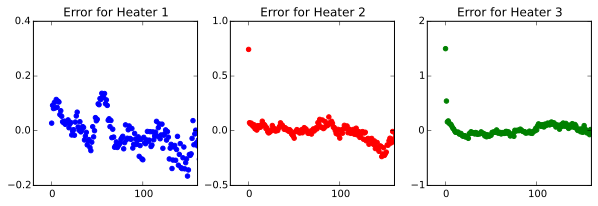

In [19]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(331)
ax1.set_title('Error for Heater 1')
ax1.locator_params(nbins=4)
ax1.set_xlim([-20,160])
ax1.scatter(x1,err1,color='blue')

ax2 = f.add_subplot(332)
ax2.set_title('Error for Heater 2')
ax2.locator_params(nbins=4)
ax2.set_xlim([-20,160])
ax2.scatter(x2,err2,color='red')

ax3 = f.add_subplot(333)
ax3.set_title('Error for Heater 3')
ax3.locator_params(nbins=4)
ax3.set_xlim([-20,160])
ax3.scatter(x3,err3,color='green')
plt.show()

As we can see, after calibration we have an order of magnitude less error.